In [1]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

pd.options.display.float_format = '{:,.5f}'.format

# Setting pandas dataframe display options
pd.set_option("display.max_rows", None)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioLab as pl

[<img style="float: right;" src="https://www.futureproof.pt/files/f_photos/f_shares/logo-future-proof_smaller.png" alt="FP" border="0">](https://www.futureproof.pt/)

In [2]:
ISINs = ['IE00B18GC888', 'IWDA']
Nomes = ['VG_GB', 'IWDA']

fundos = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]['2015-06-23':]

fundos.columns = Nomes
fundos = fundos.dropna()
fundos = pl.normalize(fundos)

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

In [3]:
returns = fundos.pct_change()

In [4]:
returns.head()

VG_GB  IWDA
Date                   
2015-06-23    nan   nan
2015-06-24   0.00 -0.00
2015-06-25  -0.00 -0.00
2015-06-26  -0.00 -0.00
2015-06-27   0.00  0.00

In [5]:
returns.corr()

VG_GB  IWDA
VG_GB   1.00 -0.14
IWDA   -0.14  1.00

In [6]:
from pandas.tseries.offsets import DateOffset
plus_1_year = returns.iloc[0].name + DateOffset(years=1)

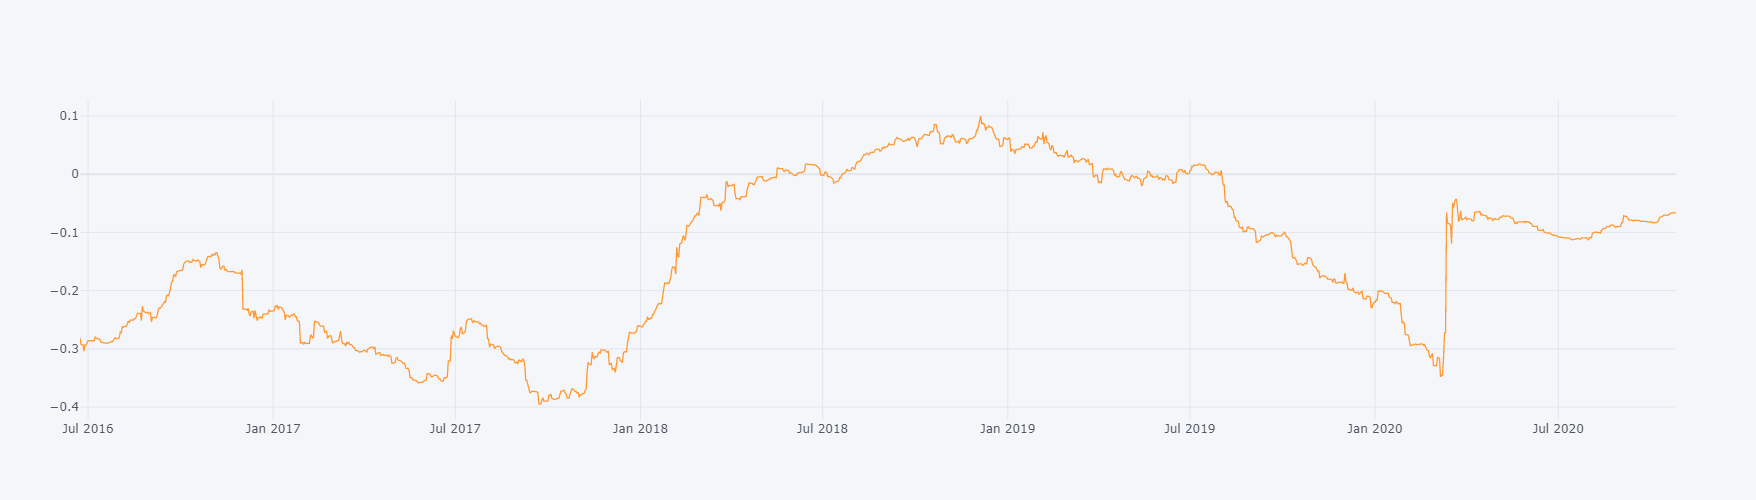

In [7]:
returns['VG_GB'].rolling("365D").corr(returns['IWDA'])[plus_1_year:].iplot(dimensions=pl.dimensions)

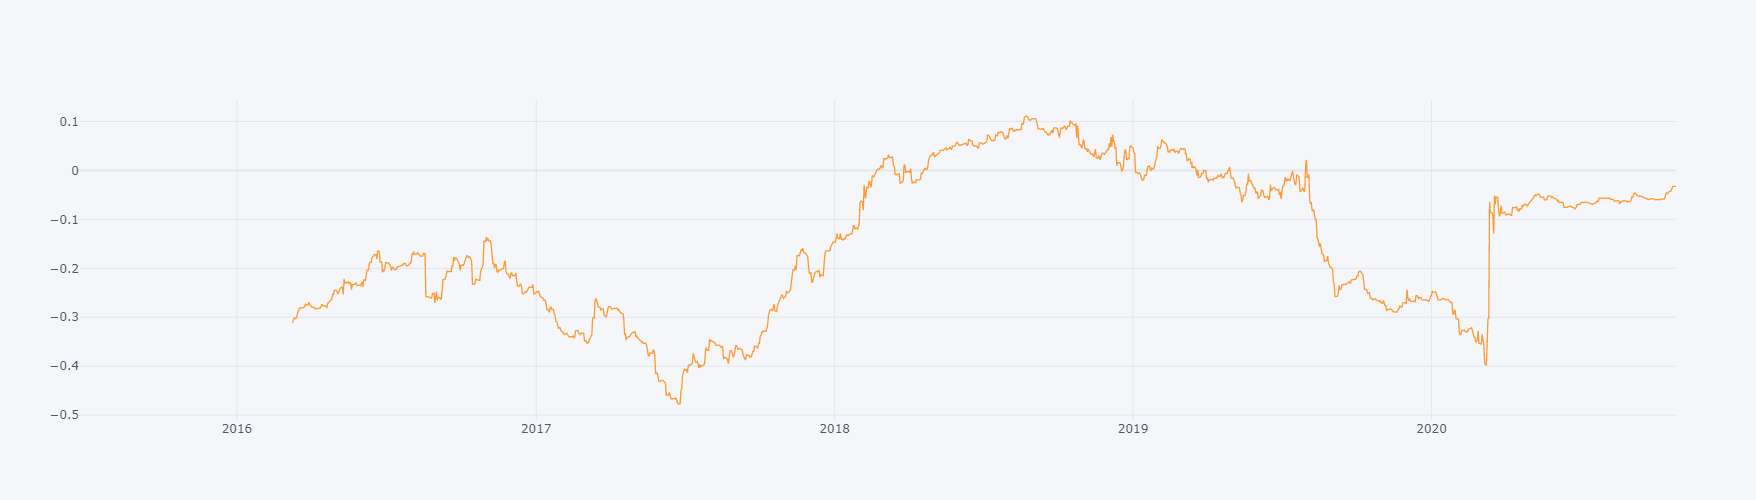

In [8]:
returns['VG_GB'].rolling(260).corr(returns['IWDA']).iplot(dimensions=pl.dimensions)

### Comparação de carteiras "modelo" de ETFs (usando Vanguard Global Bond e IWDA)

In [9]:
pl.print_title('Análise desde ' +  Begin + ' até ' + End)

**Análise desde 2015-06-23 até 2020-10-26**

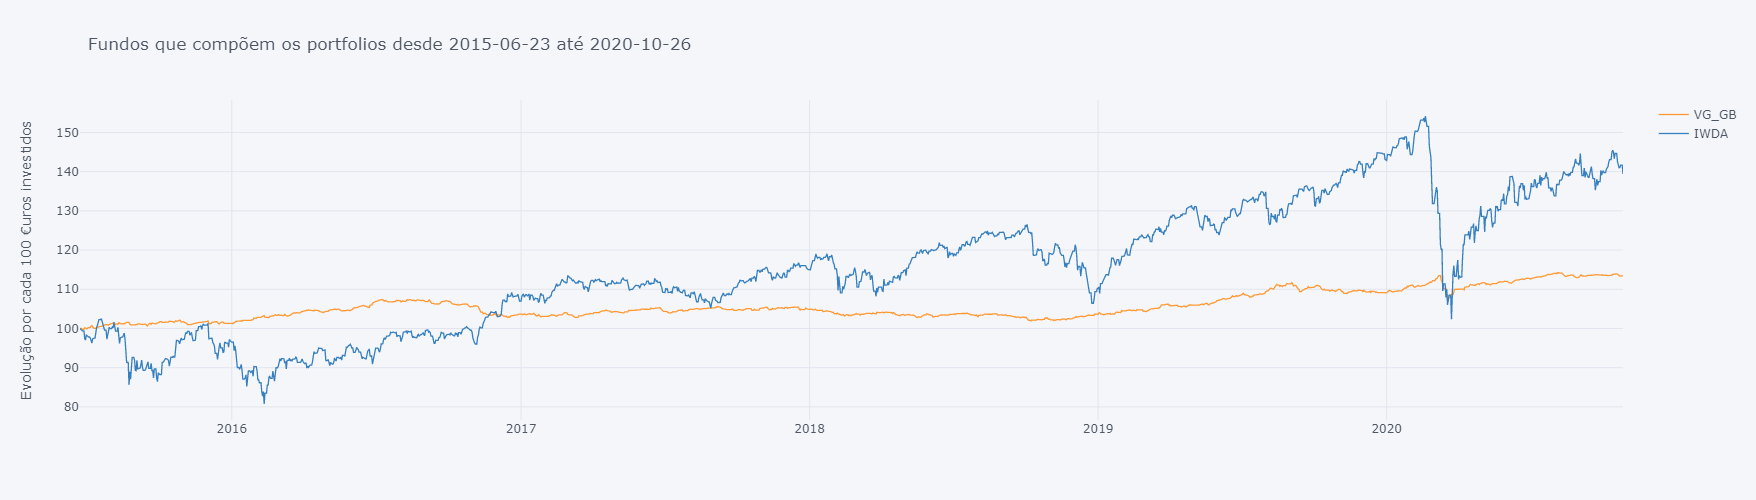

In [10]:
fundos.iplot(dimensions=pl.dimensions, title='Fundos que compõem os portfolios desde ' +  Begin + ' até ' + End,
             yTitle='Evolução por cada 100 €uros investidos')

In [11]:
# nr = 0

# pl.print_title('Quadro de performance de ' + fundos.columns[nr])
# pl.compute_ms_performance_table(fundos[[fundos.columns[nr]]])

In [12]:
# nr = 1

# pa.print_title('Quadro de performance de ' + fundos.columns[nr])
# pa.compute_ms_performance_table(fundos[[fundos.columns[nr]]])

In [13]:
def compute_portfolio(quotes, weights, rebalance='yearly', start_amount=100):
    from datetime import datetime
    from dateutil.relativedelta import relativedelta

    Start = quotes.index[0]
    End = quotes.index[-1]
    more_than_year = pd.to_datetime(Start) + relativedelta(months=12) < pd.to_datetime(End)
    more_than_quarter = pd.to_datetime(Start) + relativedelta(months=3) < pd.to_datetime(End)
    more_than_month = pd.to_datetime(Start) + relativedelta(months=1) <= pd.to_datetime(End)

    returns_all = pd.DataFrame()
    quotes_pesos_all = pd.DataFrame()
    weights_all = pd.DataFrame()
    n = -1
    
    if rebalance == 'yearly' and more_than_year:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='A')
    elif rebalance == 'yearly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == 'quarterly' and more_than_quarter:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='Q')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])    
    elif rebalance == 'monthly' and more_than_month:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='M')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == False:
        rebalance_dates = pd.to_datetime([End]) 
    

    for i in np.arange(len(rebalance_dates)):
        n+=1
        break_point_future = rebalance_dates[n]
        break_point_past = rebalance_dates[n-1]
        # Até ao primeiro breakpoint
        if n == 0:
            quotes_norm_periodo = pl.normalize(quotes[:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
        # # Break points a seguir
        if n > 0 and n < len(rebalance_dates):
            quotes_norm_periodo = pl.normalize(quotes[break_point_past:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
        # last break point
        if n == len(rebalance_dates) - 1:
            # print(n)
            quotes_norm_periodo = pl.normalize(quotes[break_point_future:])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])

    portfolio = pl.normalize(pl.compute_time_series(returns_all)) * (start_amount/100)
    portfolio = portfolio[~portfolio.index.duplicated(keep='first')]
    weights_all = weights_all[~weights_all.index.duplicated(keep='first')]
    quotes_pesos_all = quotes_pesos_all[~quotes_pesos_all.index.duplicated(keep='first')]
    weights_all = weights_all.div(weights_all.sum(axis=1), axis=0)
    weights_all = weights_all[:-1]
    
    return portfolio, weights_all, quotes_pesos_all

In [26]:
agressivo, weights_agressivo, contribution_agressivo = compute_portfolio(fundos, [0.2, 0.8])
moderado, weights_moderado, contribution_moderado = compute_portfolio(fundos, [0.5, 0.5])
conservador, weights_conservador, contribution_conservador = compute_portfolio(fundos, [0.7, 0.3])

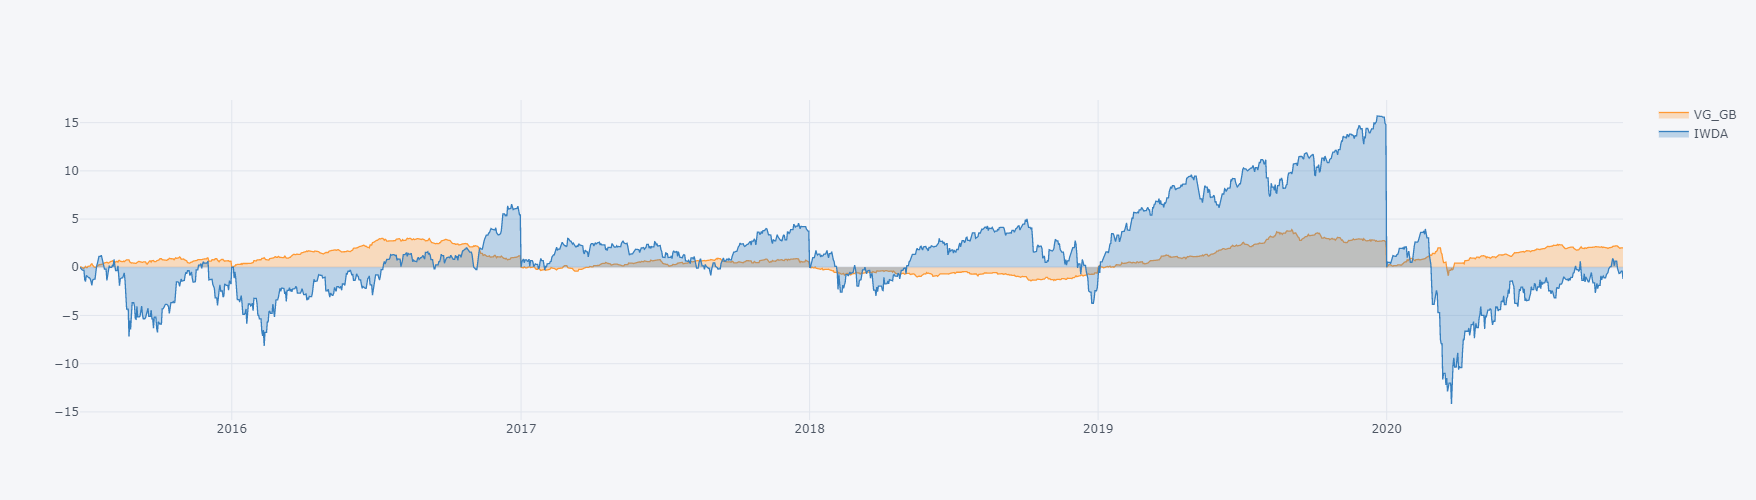

In [27]:
c_moderado = contribution_moderado.copy() - 50
Portfolio = contribution_moderado.sum(axis=1) - 100
c_moderado.iplot(dimensions=pl.dimensions, fill=True)

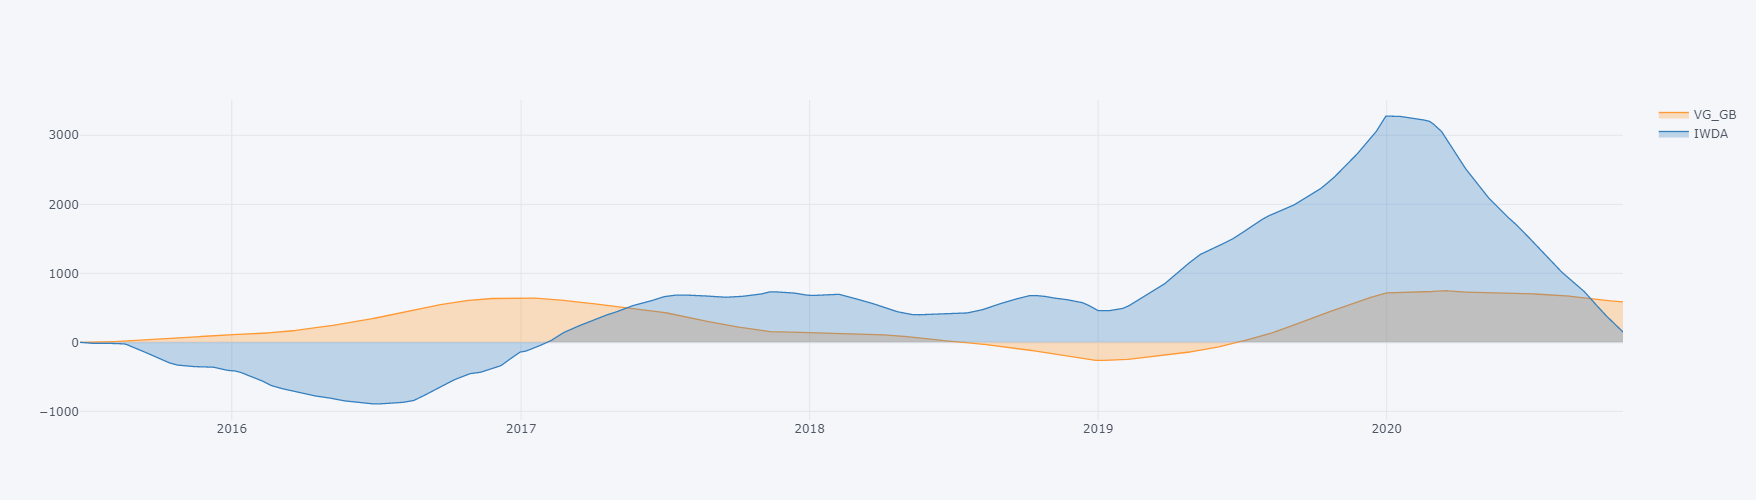

In [28]:
data = c_moderado.rolling('365D').sum()
Portfolio = Portfolio.rolling('365D').sum()
data.iplot(dimensions=pl.dimensions, fill=True)

In [35]:
data.div(Portfolio, axis=1)

#Portfolio.iplot(dimensions=pl.dimensions, fill=True)

2015-06-23 00:00:00  2015-06-24 00:00:00  2015-06-25 00:00:00  2015-06-26 00:00:00  2015-06-27 00:00:00  2015-06-28 00:00:00  2015-06-29 00:00:00  2015-06-30 00:00:00  2015-07-01 00:00:00  2015-07-02 00:00:00  ...  2020-10-19 00:00:00  2020-10-20 00:00:00  2020-10-21 00:00:00  2020-10-22 00:00:00  2020-10-23 00:00:00  2020-10-24 00:00:00  2020-10-25 00:00:00  2020-10-26 00:00:00  IWDA  VG_GB
Date                                                                                                                                                                                                                          ...                                                                                                                                                                                     
2015-06-23                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-24                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-25                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-26                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-27                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-28                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-29                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan   nan    nan
2015-06-30                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan                  nan  ...                  nan                  nan                  nan                  nan                  nan                  n

In [20]:
pd.set_option("display.max_rows", None)
data

VG_GB     IWDA  Portfolio
Date                                  
2015-06-23    0.00     0.00       0.00
2015-06-24    0.05    -0.11      -0.07
2015-06-25    0.04    -0.37      -0.33
2015-06-26   -0.07    -0.67      -0.74
2015-06-27   -0.17    -0.98      -1.15
2015-06-28   -0.28    -1.29      -1.57
2015-06-29   -0.20    -2.59      -2.79
2015-06-30   -0.11    -4.07      -4.18
2015-07-01   -0.14    -4.91      -5.06
2015-07-02   -0.18    -5.88      -6.06
2015-07-03   -0.09    -6.97      -7.06
2015-07-04    0.00    -8.06      -8.06
2015-07-05    0.09    -9.15      -9.05
2015-07-06    0.23   -10.36     -10.14
2015-07-07    0.53   -11.86     -11.33
2015-07-08    0.89   -13.73     -12.84
2015-07-09    1.11   -15.06     -13.94
2015-07-10    1.14   -16.29     -15.15
2015-07-11    1.16   -17.52     -16.36
2015-07-12    1.18   -18.74     -17.57
2015-07-13    1.17   -18.95     -17.78
2015-07-14    1.22   -18.84     -17.62
2015-07-15    1.39   -18.44     -17.06
2015-07-16    1.59   -17.46     -15.88
2015-07-17    1.85   -16.34     -14.49
2015-07-18    2.11   -15.21     -13.10
2015-07-19    2.37   -14.08     -11.72
2015-07-20    2.63   -12.84     -10.21
2015-07-21    2.90   -12.11      -9.21
2015-07-22    3.24   -11.59      -8.35
2015-07-23    3.65   -11.42      -7.77
2015-07-24    4.13   -11.62      -7.49
2015-07-25    4.61   -11.83      -7.22
2015-07-26    5.09   -12.03      -6.94
2015-07-27    5.61   -13.39      -7.78
2015-07-28    6.08   -14.21      -8.13
2015-07-29    6.51   -14.47      -7.96
2015-07-30    7.00   -14.30      -7.31
2015-07-31    7.60   -14.31      -6.70
2015-08-01    8.21   -14.31      -6.10
2015-08-02    8.82   -14.32      -5.50
2015-08-03    9.49   -14.13      -4.64
2015-08-04   10.09   -14.03      -3.94
2015-08-05   10.53   -13.23      -2.70
2015-08-06   11.03   -13.14      -2.12
2015-08-07   11.62   -13.48      -1.86
2015-08-08   12.22   -13.82      -1.59
2015-08-09   12.82   -14.15      -1.33
2015-08-10   13.34   -14.01      -0.67
2015-08-11   14.04   -14.73      -0.69
2015-08-12   14.75   -16.64      -1.88
2015-08-13   15.37   -17.83      -2.46
2015-08-14   15.95   -18.92      -2.98
2015-08-15   16.52   -20.02      -3.49
2015-08-16   17.10   -21.11      -4.01
2015-08-17   17.74   -21.89      -4.15
2015-08-18   18.32   -22.48      -4.16
2015-08-19   18.98   -23.89      -4.91
2015-08-20   19.71   -26.35      -6.63
2015-08-21   20.49   -30.68     -10.20
2015-08-22   21.26   -35.02     -13.76
2015-08-23   22.03   -39.35     -17.32
2015-08-24   22.80   -46.53     -23.73
2015-08-25   23.34   -52.06     -28.72
2015-08-26   23.80   -58.51     -34.71
2015-08-27   24.24   -62.68     -38.44
2015-08-28   24.70   -66.36     -41.67
2015-08-29   25.15   -70.04     -44.89
2015-08-30   25.61   -73.72     -48.11
2015-08-31   26.00   -77.77     -51.77
2015-09-01   26.43   -83.11     -56.69
2015-09-02   26.83   -88.51     -61.68
2015-09-03   27.31   -92.55     -65.24
2015-09-04   27.91   -97.70     -69.80
2015-09-05   28.51  -102.85     -74.35
2015-09-06   29.10  -108.00     -78.90
2015-09-07   29.68  -113.05     -83.38
2015-09-08   30.20  -117.73     -87.53
2015-09-09   30.73  -121.75     -91.02
2015-09-10   31.23  -126.68     -95.45
2015-09-11   31.78  -132.02    -100.24
2015-09-12   32.34  -137.36    -105.02
2015-09-13   32.89  -142.70    -109.81
2015-09-14   33.44  -147.91    -114.47
2015-09-15   33.81  -152.71    -118.90
2015-09-16   34.13  -156.99    -122.86
2015-09-17   34.57  -161.25    -126.68
2015-09-18   35.22  -166.33    -131.11
2015-09-19   35.87  -171.42    -135.55
2015-09-20   36.52  -176.50    -139.98
2015-09-21   37.06  -180.94    -143.89
2015-09-22   37.74  -186.30    -148.56
2015-09-23   38.40  -191.66    -153.25
2015-09-24   39.10  -197.98    -158.87
2015-09-25   39.68  -203.14    -163.46
2015-09-26   40.27  -208.31    -168.04
2015-09-27   40.85  -213.48    -172.63
2015-09-28   41.53  -219.81    -178.29
2015-09-29   42.24  -226.58    -184.34
2015-09-30   42.94  -232.23    -189.29
2015-10-01   43.70  -238.05    -194

In [120]:
c_moderado

VG_GB      IWDA  Portfolio
Date                                    
2015-06-23  0.00000   0.00000    0.00000
2015-06-24  0.04603  -0.11456   -0.06854
2015-06-25 -0.00511  -0.25458   -0.25970
2015-06-26 -0.10739  -0.30550   -0.41289
2015-06-27 -0.10739  -0.30550   -0.41289
2015-06-28 -0.10739  -0.30550   -0.41289
2015-06-29  0.08182  -1.30474   -1.22291
2015-06-30  0.08694  -1.47658   -1.38964
2015-07-01 -0.03068  -0.84649   -0.87717
2015-07-02 -0.04091  -0.96741   -1.00833
2015-07-03  0.09205  -1.08834   -0.99629
2015-07-04  0.09205  -1.08834   -0.99629
2015-07-05  0.09205  -1.08834   -0.99629
2015-07-06  0.13297  -1.21563   -1.08267
2015-07-07  0.30684  -1.50204   -1.19519
2015-07-08  0.36310  -1.87118   -1.50808
2015-07-09  0.21990  -1.32383   -1.10393
2015-07-10  0.02046  -1.22836   -1.20790
2015-07-11  0.02046  -1.22836   -1.20790
2015-07-12  0.02046  -1.22836   -1.20790
2015-07-13 -0.00511  -0.20367   -0.20878
2015-07-14  0.05114   0.10820    0.15934
2015-07-15  0.16365   0.39460    0.55825
2015-07-16  0.19945   0.98014    1.17959
2015-07-17  0.26082   1.12653    1.38734
2015-07-18  0.26082   1.12653    1.38734
2015-07-19  0.26082   1.12653    1.38734
2015-07-20  0.26082   1.24745    1.50827
2015-07-21  0.27616   0.72556    1.00172
2015-07-22  0.33753   0.52189    0.85942
2015-07-23  0.40401   0.17184    0.57585
2015-07-24  0.48072  -0.20367    0.27705
2015-07-25  0.48072  -0.20367    0.27705
2015-07-26  0.48072  -0.20367    0.27705
2015-07-27  0.52163  -1.36202   -0.84038
2015-07-28  0.47049  -0.81466   -0.34417
2015-07-29  0.42447  -0.26095    0.16352
2015-07-30  0.49095   0.16548    0.65643
2015-07-31  0.60857  -0.00636    0.60221
2015-08-01  0.60857  -0.00636    0.60221
2015-08-02  0.60857  -0.00636    0.60221
2015-08-03  0.66994   0.19094    0.86088
2015-08-04  0.59834   0.09547    0.69381
2015-08-05  0.43981   0.80830    1.24811
2015-08-06  0.49606   0.08274    0.57880
2015-08-07  0.59834  -0.33732    0.26102
2015-08-08  0.59834  -0.33732    0.26102
2015-08-09  0.59834  -0.33732    0.26102
2015-08-10  0.52163   0.14638    0.66802
2015-08-11  0.70062  -0.72556   -0.02494
2015-08-12  0.71085  -1.90300   -1.19215
2015-08-13  0.61369  -1.19017   -0.57649
2015-08-14  0.57789  -1.09470   -0.51682
2015-08-15  0.57789  -1.09470   -0.51682
2015-08-16  0.57789  -1.09470   -0.51682
2015-08-17  0.63926  -0.77648   -0.13722
2015-08-18  0.58300  -0.59190   -0.00890
2015-08-19  0.65460  -1.40657   -0.75197
2015-08-20  0.73642  -2.46309   -1.72666
2015-08-21  0.77222  -4.33427   -3.56205
2015-08-22  0.77222  -4.33427   -3.56205
2015-08-23  0.77222  -4.33427   -3.56205
2015-08-24  0.76711  -7.17923   -6.41212
2015-08-25  0.54209  -5.52444   -4.98235
2015-08-26  0.46026  -6.45367   -5.99340
2015-08-27  0.43981  -4.17515   -3.73535
2015-08-28  0.45515  -3.67872   -3.22357
2015-08-29  0.45515  -3.67872   -3.22357
2015-08-30  0.45515  -3.67872   -3.22357
2015-08-31  0.39378  -4.04786   -3.65408
2015-09-01  0.42958  -5.34623   -4.91665
2015-09-02  0.39890  -5.39078   -4.99189
2015-09-03  0.48072  -4.04786   -3.56714
2015-09-04  0.59834  -5.14893   -4.55059
2015-09-05  0.59834  -5.14893   -4.55059
2015-09-06  0.59834  -5.14893   -4.55059
2015-09-07  0.57277  -5.05346   -4.48069
2015-09-08  0.52675  -4.67795   -4.15121
2015-09-09  0.52675  -4.02240   -3.49566
2015-09-10  0.50118  -4.92617   -4.42499
2015-09-11  0.55232  -5.33987   -4.78755
2015-09-12  0.55232  -5.33987   -4.78755
2015-09-13  0.55232  -5.33987   -4.78755
2015-09-14  0.55232  -5.21258   -4.66026
2015-09-15  0.36821  -4.79888   -4.43067
2015-09-16  0.32218  -4.28335   -3.96117
2015-09-17  0.43981  -4.25153   -3.81172
2015-09-18  0.64948  -5.08529   -4.43580
2015-09-19  0.64948  -5.08529   -4.43580
2015-09-20  0.64948  -5.08529   -4.43580
2015-09-21  0.53697  -4.44246   -3.90549
2015-09-22  0.68528  -5.35896   -4.67368
2015-09-23  0.65971  -5.35260   -4.69289
2015-09-24  0.70062  -6.32001   -5.61939
2015-09-25  0.58300  -5.16802   -4.58502
2015-09-26  0.58300  -5.16802   -4.58

In [98]:
# Start = contribution_moderado.index[0]
# End = contribution_moderado.index[-1]
# rebalance_dates = pd.bdate_range(start=Start, end=End, freq='AS')
# contribution = (contribution_moderado).pct_change()

# for date in rebalance_dates:
#     contribution.loc[date] = [0.0, 0.0]

In [229]:
portfolios = pl.merge_time_series(conservador, moderado)
portfolios = pl.merge_time_series(portfolios, agressivo)

In [230]:
portfolios.columns = ['Cons.', 'Mod.', 'Agr.'] 

### Portfolios:

- Portfolio Conservador:
    - 20% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 70% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)
    
    
- Portfolio Moderado:
    - 50% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 50% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)
    
    
- Portfolio Agressivo:
    - 80% IWDA (MSCI World) - [Homepage](https://www.ishares.com/nl/particuliere-belegger/nl/producten/251882/ishares-msci-world-ucits-etf-acc-fund) (tem de se traduzir para inglês usando a funcionalidade "translate to english" do chrome)
    - 20% Vanguard Global Bond - [Homepage](https://global.vanguard.com/portal/site/kiids/pt/pt/documents) // [Kiid](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417)

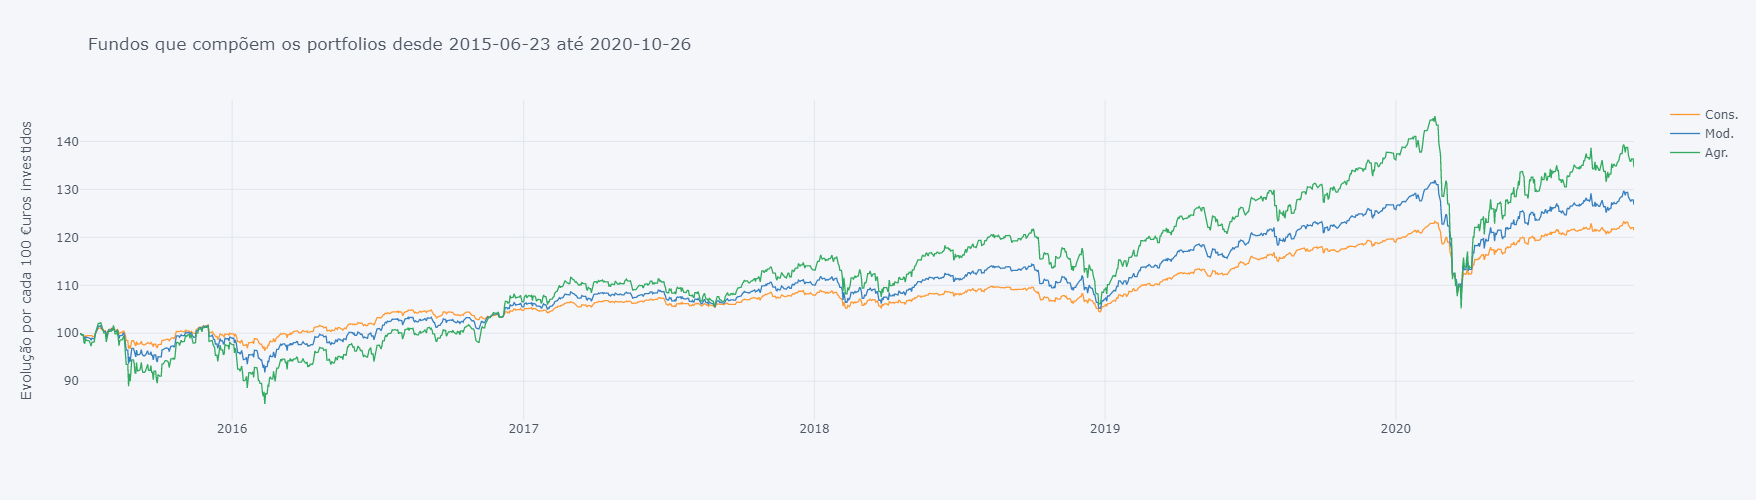

In [231]:
portfolios.iplot(dimensions=pl.dimensions, title='Fundos que compõem os portfolios desde ' +  Begin + ' até ' + End,
                 yTitle='Evolução por cada 100 €uros investidos')

In [232]:
# def compute_rolling_cagr_with_offset(data, years):
#     start = data.index[0]
#     end = data.index[-1]
#     start_offset = start + DateOffset(years=years)
#     end_offset   = end - DateOffset(years=years)
#     data_offset = data[start_offset:]
#     data = data[:end_offset]
#     df = (pd.DataFrame(data_offset.values / data.values) - 1)
#     df.columns = data_offset.columns
#     df.index = data_offset.index
#     df = df.groupby(df.index).last()
    
#     return df

In [29]:
def compute_rolling_cagr_with_shift(data, years):
    df = ((data / data.shift(365 * years, freq="D")).dropna()) -1
    df = df[~df.index.duplicated(keep='first')]
    return df

In [30]:
moderado.columns = ['moderado']
one_year_cons = compute_rolling_cagr_with_shift(moderado, years=1)
one_year_funds = compute_rolling_cagr_with_shift(fundos, years=1)

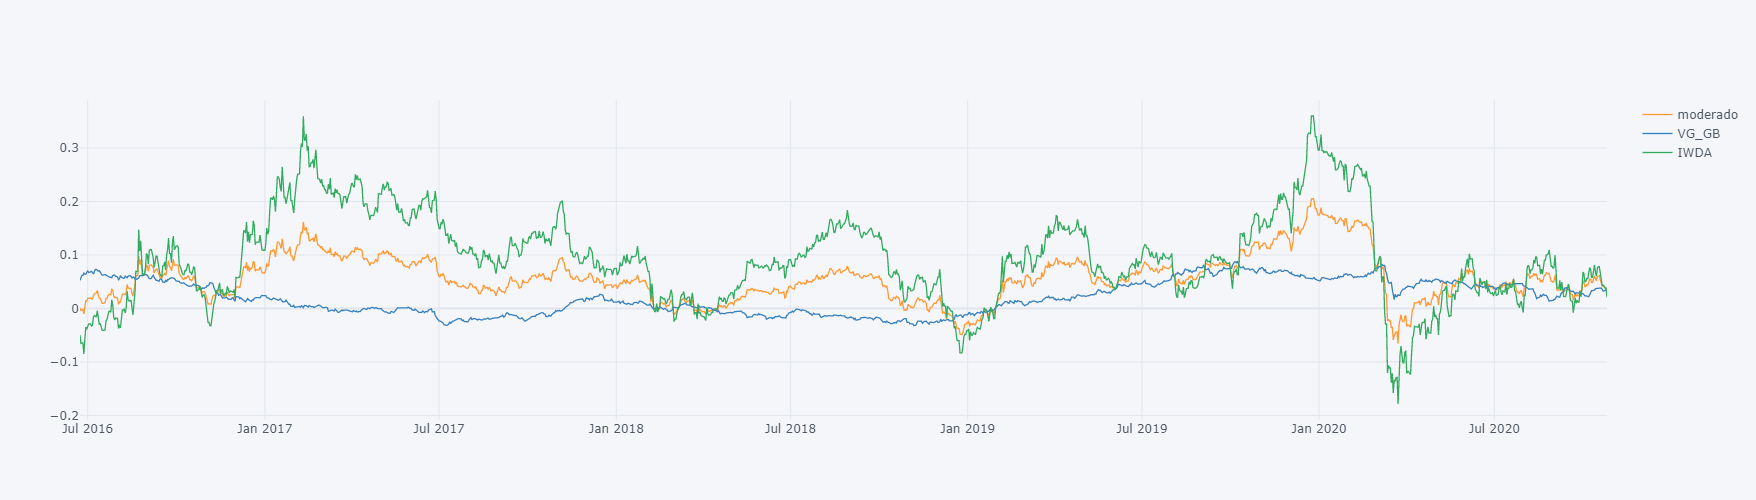

In [31]:
pl.merge_time_series(one_year_cons, one_year_funds).dropna().iplot(dimensions=pl.dimensions)

In [ ]:
round(fa.compute_drawdowns(portfolios), 2).iplot(dimensions=fa.dimensions, title='Drawdowns desde ' +  Begin + ' até ' + End, yTitle='Percentagem')

In [ ]:
pa.print_title('Quadro de performance do portfolio Conservador (70B/30E)')
pa.compute_ms_performance_table(portfolios[['Cons.']])

**Nota:** O "B" e o "E" querem dizer Bonds e Equity respectivamente

In [ ]:
pa.print_title('Quadro de performance do portfolio Moderado (50B/50E)')
pa.compute_ms_performance_table(portfolios[['Mod.']])

In [ ]:
pa.print_title('Quadro de performance do portfolio Agressivo (20B/80E)')
pa.compute_ms_performance_table(portfolios[['Agr.']])

In [ ]:
pa.print_title('Quadro de retornos anuais dos portfolios')
fundos_norm = portfolios.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance')
plt.show()

### Questão: Posso usar o IGGH/EUNA (iShares Core Global Aggregate Bond UCITS ETF) em vez do Vanguard Global bond index fund (IE00BGCZ0933)?

In [ ]:
ISINs = ['IE00B18GC888', 'AGGH_oficial']
Nomes = ['VG_GB', 'AGGH']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()
fundos = fa.normalize(fundos.loc[:'2020-04-30'])

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

In [ ]:
fundos.iplot(dimensions=pa.dimensions, title = 'Vanguard Global bond index fund vs iShares Core Global Aggregate Bond UCITS ETF',
            yTitle='Crescimento de cada 100 €uros investidos')

Os activos parecem ser suficientemente semelhantes para se poder usar qualquer um deles.

## Comparação do Vanguard Global Bond com o Xtrackers II Global Government Bond UCITS ETF 1C - EUR Hedged

In [ ]:
# Downloading funds and creating quotes and returns dataframes
Begin = '2000-03-10'
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

Tickers =  ['DBZB.XETRA']

ETFs = pd.DataFrame()

# Download
for ticker in Tickers:
    url = "https://eodhistoricaldata.com/api/eod/" + str(ticker) + "?api_token=5c982bff80deb2.22427269&period=d."
    ETF = pd.read_csv(url, index_col = 'Date', parse_dates = True)[['Adjusted_close']].iloc[:-1, :]
    ETFs = ETFs.merge(ETF, left_index = True, right_index = True, how='outer')
    
ETFs.columns = Tickers
ETFs = ETFs.fillna(method='ffill')
ETFs = ETFs.replace(to_replace=0, method='ffill')
ETFs.columns = ['DBZB']

ISINs = ['IE00B18GC888']
Nomes = ['VG_GB']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()

Begin = str(fundos.iloc[0].name)[0:10]
End = str(fundos.iloc[-1].name)[0:10]

fundos = pa.merge_time_series(ETFs, fundos, how='inner')
fundos = pa.normalize(fundos)

In [ ]:
fundos.iplot(dimensions=pa.dimensions,
             title= 'Vanguard Global Bond vs Xtrackers II Global Government Bond',
             yTitle='Valor por cada 100 €uros investidos')

In [ ]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)